In [9]:
import numpy as np
import os
from scipy.stats import qmc

def matern_kernel(X1, X2, sigma, beta):
    """
    Compute the Matérn kernel (ν=3.5) between two sets of inputs.
    K(x1, x2) = sigma^2 * (1 + a1*r + a2*r^2 + a3*r^3) * exp(-r)
    where r is the scaled distance: r = sqrt(sum((x1[i] - x2[i])^2 / beta[i]^2))
    
    Parameters:
    - X1: ndarray of shape (n1, d), first set of points
    - X2: ndarray of shape (n2, d), second set of points
    - sigma: float, output variance (amplitude parameter)
    - beta: ndarray of shape (d,), length scales for each dimension
    
    Returns:
    - K: ndarray of shape (n1, n2), kernel matrix
    """
    # Reshape inputs for broadcasting
    X1_expanded = X1[:, None, :]  # Shape: (n1, 1, d)
    X2_expanded = X2[None, :, :]  # Shape: (1, n2, d)
    
    # Compute squared differences for each dimension
    diff_squared = (X1_expanded - X2_expanded) ** 2
    
    # Scale the squared differences by beta^2
    scaled_diff_squared = diff_squared / (beta ** 2)
    
    # Sum over dimensions and take sqrt to get scaled distance r
    r = np.sqrt(np.sum(scaled_diff_squared, axis=-1))
    
    # Constants for ν=3.5
    a0 = 1.0
    a1 = 1.0
    a2 = 2.0/5.0
    a3 = 1.0/15.0
    
    # Compute the polynomial part: (1 + sqrt(7)*r + 14*r^2/5 + 7*sqrt(7)*r^3/15)
    polynomial = a0 + a1*r + a2*(r**2) + a3*(r**3)
    
    # Compute final kernel values
    return sigma**2 * polynomial * np.exp(-r)

def power_exponential_kernel(X1, X2, sigma, beta, alpha):
    """
    Compute the Power Exponential kernel between two sets of inputs.
    K(x1, x2) = sigma^2 * exp(-power_distance)
    where:
    power_distance = (scaled_distance)^alpha
    scaled_distance = sqrt(sum((|x1[i] - x2[i]|^2) / beta[i]^2))
    
    Parameters:
    - X1: ndarray of shape (n1, d), first set of points
    - X2: ndarray of shape (n2, d), second set of points
    - sigma: float, output variance (amplitude parameter)
    - beta: ndarray of shape (d,), length scales for each dimension
    - alpha: float, smoothness parameter
    
    Returns:
    - K: ndarray of shape (n1, n2), kernel matrix
    """
    # Reshape inputs for broadcasting
    X1_expanded = X1[:, None, :]  # Shape: (n1, 1, d)
    X2_expanded = X2[None, :, :]  # Shape: (1, n2, d)
    
    # Compute squared differences for each dimension
    diff_squared = (X1_expanded - X2_expanded) ** 2
    
    # Scale the squared differences by beta^2
    scaled_diff_squared = diff_squared / (beta ** 2)
    
    # Sum over dimensions and take sqrt to get scaled_distance
    scaled_distance = np.sqrt(np.sum(scaled_diff_squared, axis=-1))
    
    # Compute power_distance
    power_distance = scaled_distance ** alpha
    
    # Compute final kernel values
    return sigma**2 * np.exp(-power_distance)

In [17]:

# Create data directory if it doesn't exist
data_dir = './maternSimuData'
os.makedirs(data_dir, exist_ok=True)

# Simulation parameters
n_total = 7000
n_train = 5000
n_test = n_total - n_train
d = 8  # Input dimensions

# Generate meaningful hyperparameters
sigma = 1.0  # Amplitude parameter
# beta = np.array([0.1])  # Length scales
beta = np.array([.01, .01, 5., 5., 5., 5., 5., 5.])  # Length scales
# alpha = 2.0  # Smoothness parameter

# Generate input space
np.random.seed(42)
# Create LHS sampler
sampler = qmc.LatinHypercube(d=d, seed=42)
X_all = sampler.random(n=n_total)
# X_all = np.random.rand(n_total, d)  # Uniform [0,1] for all dimensions

# Split into training and test sets
X_train = X_all[:n_train]
X_test = X_all[n_train:]

# Compute the full covariance matrix
# K_train = power_exponential_kernel(X_train, X_train, sigma, beta, alpha)
K_train = matern_kernel(X_train, X_train, sigma, beta)

# Add nugget term for numerical stability
nugget = 0 # 1e-6
K_train += nugget * np.eye(n_train)

# Generate samples from GP prior
Y_train = np.random.multivariate_normal(mean=np.zeros(n_train), cov=K_train)

# Compute test set outputs using conditional distribution
# K_test = power_exponential_kernel(X_test, X_test, sigma, beta, alpha)
# K_cross = power_exponential_kernel(X_train, X_test, sigma, beta, alpha)
K_test = matern_kernel(X_test, X_test, sigma, beta)
K_cross = matern_kernel(X_train, X_test, sigma, beta)
K_inv_y = np.linalg.solve(K_train, Y_train)
mean_test = K_cross.T @ K_inv_y
cov_test = K_test - K_cross.T @ np.linalg.solve(K_train, K_cross)
Y_test = np.random.multivariate_normal(mean=mean_test, cov=cov_test)

## add 1 to Y_test and Y_train to avoid RMSPE = 0
# Y_test += 1
# Y_train += 1

# Save the datasets, please save in csv format
training_data = np.hstack((X_train, Y_train.reshape(-1, 1)))
np.savetxt(os.path.join(data_dir, 'training_data.csv'), training_data, delimiter=',')

test_data = np.hstack((X_test, Y_test.reshape(-1, 1)))
np.savetxt(os.path.join(data_dir, 'test_data.csv'), test_data, delimiter=',')

# Save the datasets, please save in csv format
# set all observations to zero
training_data = np.hstack((X_train, np.zeros(n_train).reshape(-1, 1)))
np.savetxt(os.path.join(data_dir, 'training_data_kl.csv'), training_data, delimiter=',')

test_data = np.hstack((X_test, np.zeros(n_test).reshape(-1, 1)))
np.savetxt(os.path.join(data_dir, 'test_data_kl.csv'), test_data, delimiter=',')


# Save hyperparameters separately for reference
# save in double precision
# hyperparameters = np.hstack(([sigma, alpha, nugget], beta))
hyperparameters = np.hstack(([sigma, nugget], beta))
np.savetxt(os.path.join(data_dir, 'hyperparameters.csv'), hyperparameters, delimiter=',', fmt='%.5f')

print("Generated and saved dataset with the following properties:")
print(f"Training samples: {n_train}")
print(f"Test samples: {n_test}")
print(f"Input dimensions: {d}")
print(f"Length scales (beta): {beta}")
print(f"Output variance (sigma²): {sigma**2}")
# print(f"Smoothness parameter (alpha): {alpha}")
print("\nFiles saved in ./data/:")
print("- training_data.csv")
print("- test_data.csv")
print("- hyperparameters.csv")

Generated and saved dataset with the following properties:
Training samples: 5000
Test samples: 2000
Input dimensions: 8
Length scales (beta): [0.01 0.01 5.   5.   5.   5.   5.   5.  ]
Output variance (sigma²): 1.0

Files saved in ./data/:
- training_data.csv
- test_data.csv
- hyperparameters.csv


In [18]:
# Calculate log-likelihood with Y_train set to zeros
Y_zeros = np.zeros(n_train)

# Calculate terms for log-likelihood
# 1. log determinant term
sign, logdet = np.linalg.slogdet(K_train)
log_det_term = logdet

# 2. quadratic term (yᵀK⁻¹y)
quad_term = Y_zeros @ np.linalg.solve(K_train, Y_zeros)

# 3. Constant term
# const_term = n_train * np.log(2 * np.pi)
const_term = 0 # which is removed for simplicity

# Calculate log-likelihood
log_likelihood = -0.5 * (const_term + log_det_term + quad_term)

print(f"\nLog-likelihood with Y_train = 0: {log_likelihood}")


Log-likelihood with Y_train = 0: 7493.692056611184


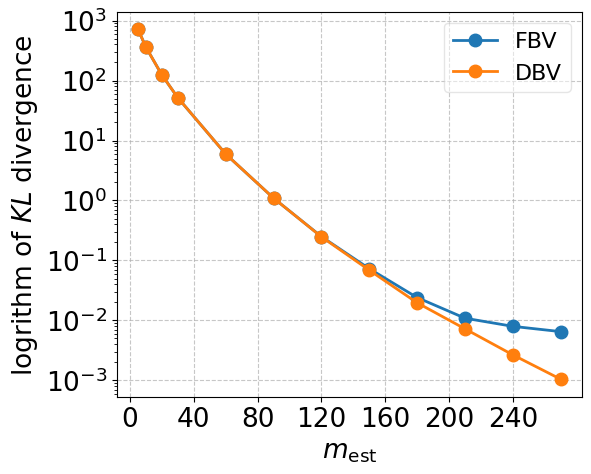

In [15]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 19})

# Reference log-likelihood from your previous calculation
reference_log_likelihood = 7493.692056611184

def extract_kl_divergence(log_files, reference_log_likelihood):
    data = []
    # Read each file and extract relevant information
    for file in log_files:
        df = pd.read_csv(file)
        
        # Extract m and isScaled from filename
        m = int(file.split('_m')[1].split('_')[0])
        precision = file.split('kl-matern72-simu-')[1].split('.csv')[0]
        
        # Calculate KL divergence (difference in log-likelihood)
        kl_difference = reference_log_likelihood - df['optimized_log_likelihood'].values[0]
        
        data.append({
            'm': m,
            'KL': kl_difference,
            'precision': precision
        })
    return data

m_bv = (5, 10, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270)

# Read all log files
log_files_bv = [f'../../log/kl-matern72-simu/logFile_numPointsTotal5000_numBlocksTotal500_m{m}_seed0_isScaled1_kl-matern72-simu-{precision}.csv' for m in m_bv for precision in ['float', 'double']]
# Create empty lists to store data
data_bv = []
data_bv = extract_kl_divergence(log_files_bv, reference_log_likelihood)
df_plot_bv = pd.DataFrame(data_bv)

# Create the plot
plt.figure(figsize=(6, 5))

# Define line styles for different scaling
colors = {'float': 'red', 'double': 'blue'}

# Plot lines for scaled and non-scaled data with markers
for precision in ['float', 'double']:
    df_subset_bv = df_plot_bv[df_plot_bv['precision'] == precision].sort_values('m')  # Sort by 'm'
    if precision == "float":
        precision_label = "F"
    else:
        precision_label = "D"
    plt.plot(df_subset_bv['m'], df_subset_bv['KL'], 
             label= precision_label + "B" + "V",
             marker="o",  # Add markers to each point
             markersize=9,
             linestyle='-',  # Different line styles
            #  color=colors[scaled],
             linewidth=2)


# plt.title('KL Divergence vs m')
plt.xlabel(r'$m_{\text{est}}$')
plt.ylabel(r'logrithm of $\mathit{KL}$ divergence')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(framealpha=0.5, fontsize=16)
plt.xticks(ticks=np.arange(0, max(m_bv)+1, 40))  

# Save the plot
os.makedirs('./fig', exist_ok=True)
plt.savefig('./fig/kl_divergence_comparison_multiple_precision.pdf', bbox_inches='tight', dpi=300)
plt.show()

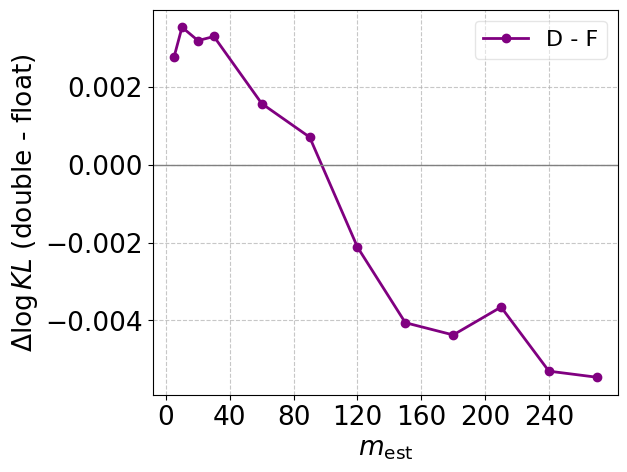

In [16]:
# Plot difference in KL between double and float (double - float) vs m
pivot = df_plot_bv.pivot(index='m', columns='precision', values='KL')
missing = [p for p in ['float', 'double'] if p not in pivot.columns]
if missing:
    raise ValueError(f"Missing precisions in data: {missing}")

diff = pivot['double'] - pivot['float']

plt.figure(figsize=(6, 5))
plt.plot(diff.index, diff.values, marker='o', linewidth=2, color='purple', label='D - F')
plt.axhline(0, color='gray', linewidth=1)
plt.xlabel(r'$m_{\text{est}}$')
plt.ylabel(r'$\Delta \log \mathit{KL}$ (double - float)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(framealpha=0.5, fontsize=16)
plt.xticks(ticks=np.arange(0, max(m_bv)+1, 40))

os.makedirs('./fig', exist_ok=True)
plt.savefig('./fig/kl_divergence_difference_double_minus_float.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
plt.rcParams.update({'font.size': 16})

m_bv_test = (5, 10, 20, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 500)

# Read the CSV file
precision = ('float', 'double')

def get_mspe_values(filename):
    df = pd.read_csv(filename)
    return df['mspe']

float_filename = '../../log/mspe-matern72-simu/logFile_numPointsTotal5000_numBlocksTotal500_m1_seed0_isScaled1_mspe-matern72-simu-float.csv'
double_filename = '../../log/mspe-matern72-simu/logFile_numPointsTotal5000_numBlocksTotal500_m1_seed0_isScaled1_mspe-matern72-simu-double.csv'
float_mspe_values = get_mspe_values(float_filename)
double_mspe_values = get_mspe_values(double_filename)

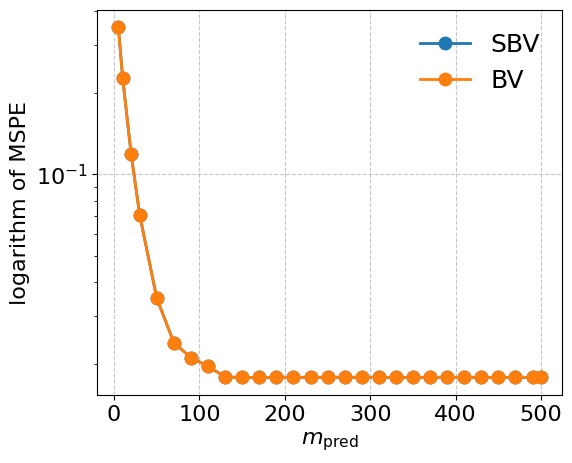

In [20]:
# Create the plot
plt.figure(figsize=(6, 5))

plt.plot(m_bv_test, float_mspe_values, 
             label="SBV",
             marker="o",  # Add markers to each point
             markersize=9,
             linestyle="-",  # Different line styles
            #  color=colors['Scaled'],
             linewidth=2)
plt.plot(m_bv_test, double_mspe_values, 
             label="BV",
             marker="o",  # Add markers to each point
             markersize=9,
             linestyle='-',  # Different line styles
            #  color=colors['Not Scaled'],
             linewidth=2)


# plt.title('KL Divergence vs m')
plt.xlabel(r'$m_{\text{pred}}$')
plt.ylabel(r'logarithm of MSPE')
plt.yscale('log') 
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(frameon=False, fontsize=18)

# Save the plot
os.makedirs('./fig', exist_ok=True)
plt.savefig('./fig/mspe_comparison.pdf', bbox_inches='tight', dpi=300)
plt.show()